In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/textcnnmodel/textcnn_spamdestroyer.pth
/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv


In [45]:
import warnings
warnings.simplefilter('ignore')

In [46]:
df = pd.read_csv(r'/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv')
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [47]:
### Будем работать над копией датасета 
data = df.copy()

In [48]:
df['label'].value_counts(), df['label_num'].value_counts()

(label
 ham     3672
 spam    1499
 Name: count, dtype: int64,
 label_num
 0    3672
 1    1499
 Name: count, dtype: int64)

### Проведем анализ текстов 

In [49]:
!pip install wordcloud

In [50]:
### Необходимо удалить все знаки экранизации, знаки препинания и стоп слова
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


nltk.download('stopwords') # скачиваем из nltk стоп слова и знаки пунктуации
nltk.download('punkt')
stop_words = set(stopwords.words('english')) # множество со стоп словами для английского языка 
punctuation = set(string.punctuation) # множество со знаками пунктуации


def preprocess_text(text) -> str:
    '''
    Эта функция удаляет из текста все стоп слова и знаки пунктуации
    params: text. text for delete stop words and punctuations
    return: str. preprocessed text
    '''
    
    words = word_tokenize(text.lower())  # проведем текст через токенизатор
    filtered_words = [word for word in words if word not in stop_words and word not in punctuation] # оставим только слова не относящиейся к стоп и пунктуациям
    
    return ' '.join(filtered_words) # возвращаем в виде строки


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
### Переведем к такому формату все тексты из датасета
texts = np.array(data['text']) # создадим массив из текстов 


for _ in range(len(texts)):
    texts[_] = preprocess_text(texts[_]) # переведем каждый текст к нужному формату
    

data['text'] = texts # заменим 

In [52]:
### нужно избавиться от всех цифр и чисел
import re


def remove_numbers(text):
    '''
        Эта функция удаляет все цифры и числа из текста благодаря регулярному выражению
        params: text. text for delete numbers
        return: test without numbers
    '''
    
    text_w_numbers = re.sub(r'[\d\W_]+', ' ', text)
    
    return text_w_numbers

for i in range(len(texts)):
    texts[i] = remove_numbers(texts[i])
    
data['text'] = texts

In [53]:
from collections import Counter


text = ' '.join(list(np.array(data['text']))) # распакованные тексты 

words = text.lower().split() # список из слов по отдельности


word_freq = Counter(words) # подсчитываем частоту слов

In [54]:
from wordcloud import WordCloud # библиотека для удобное визуализации частотностей слов



wordcloudd = WordCloud(background_color='black',
                      colormap='Reds',
                      max_words=100,
                      mask=None,
                      width=3200,
                      height=3200,
                      ).generate_from_frequencies(word_freq)

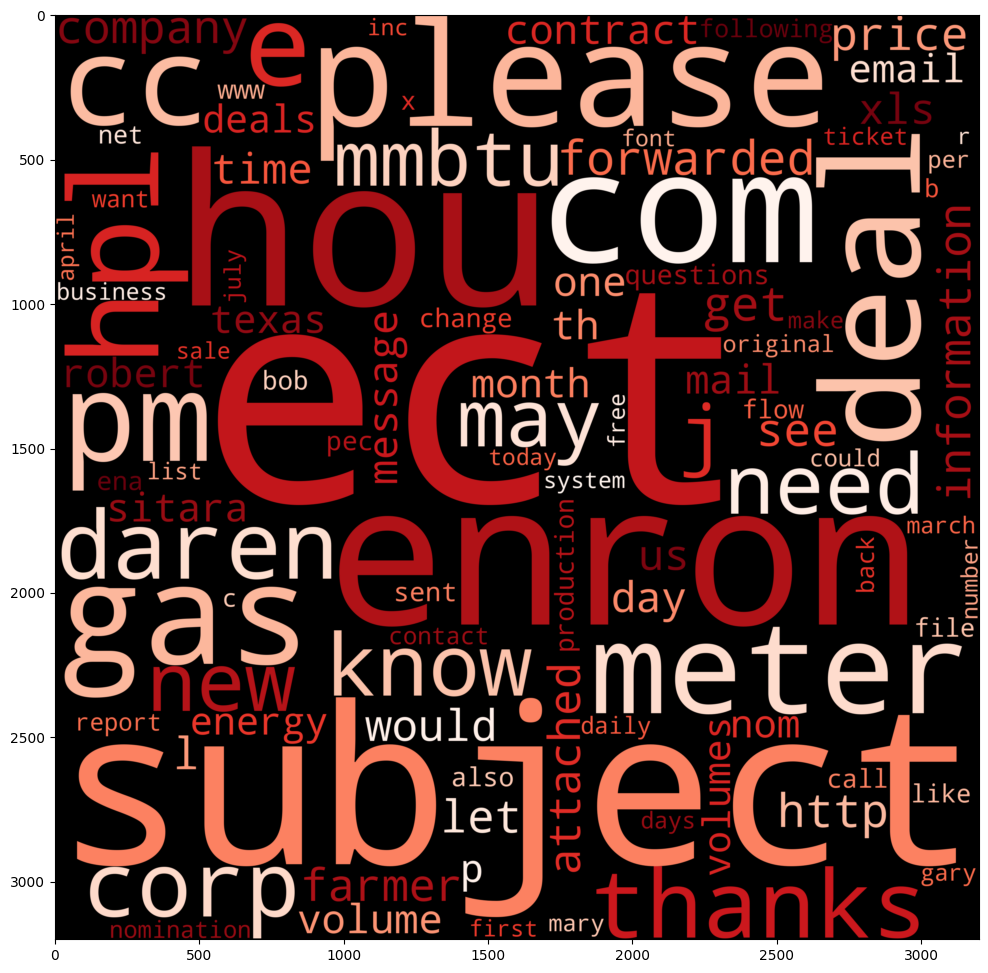

In [55]:
# Покажем на графике 
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(20, 12))

plt.imshow(wordcloudd, interpolation='bilinear')

plt.show()

In [56]:
### Посмотрим на анализ слов для спам и не спам сообщений
from collections import Counter 


spam_texts = ' '.join(list(np.array(data.query('label_num == 1')['text']))) # тексты относящиейся к спаму 


spam_words = spam_texts.lower().split() # слова из этих текстов
 

spam_freq = Counter(spam_words) # счетчик с частотами

In [57]:
spam_wordcloud = WordCloud(background_color='black',
                          colormap='Reds',
                          max_words=100,
                          mask=None,
                          width=3200,
                          height=3200,
                          ).generate_from_frequencies(spam_freq) # объект класса WordCloud для удобного отоброжения частот

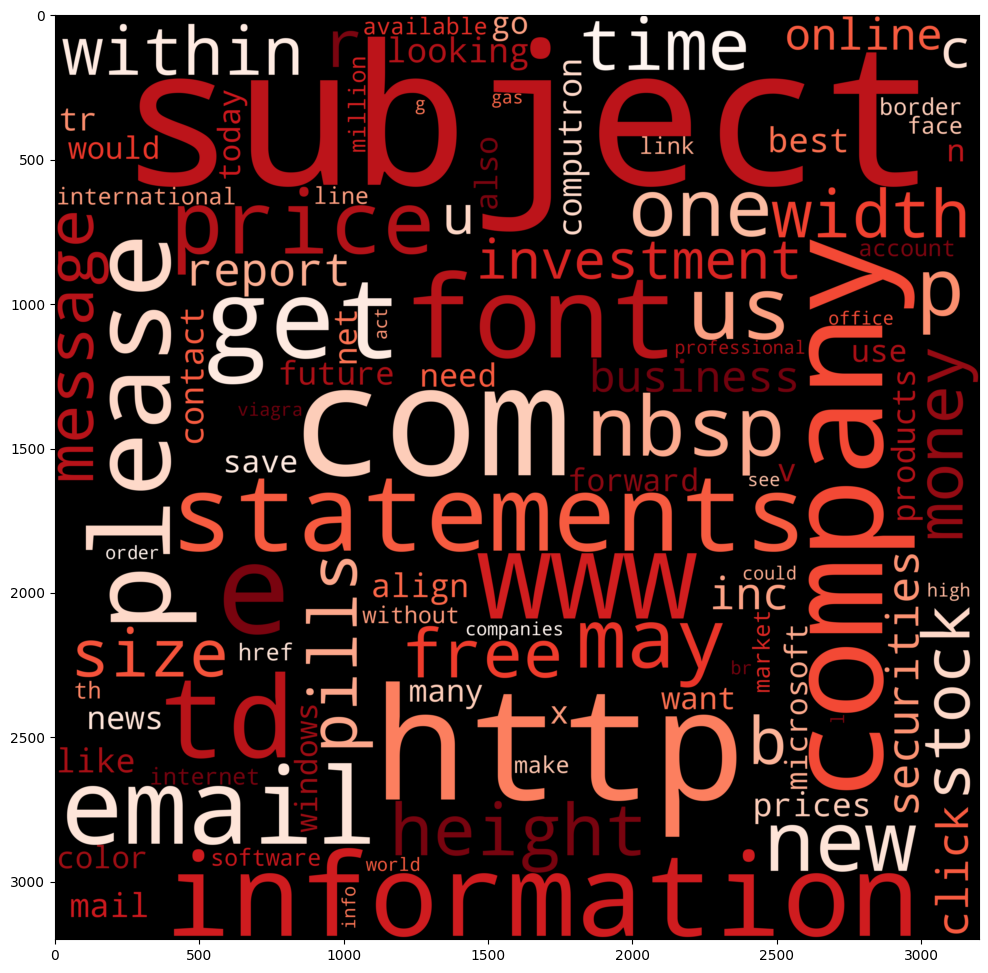

In [58]:
fig = plt.figure(figsize=(20, 12))

plt.imshow(spam_wordcloud, interpolation='bilinear')

plt.show()

In [59]:
from collections import Counter 


nspam_texts = ' '.join(list(np.array(data.query('label_num == 0')['text']))) # не спам тексты


nspam_words = nspam_texts.lower().split() # слова из этих текстов 


nspam_freq = Counter(nspam_words) # счетчик с частотами

In [60]:
nspam_wordcloud = WordCloud(background_color='black',
                          colormap='Reds',
                          max_words=100,
                          mask=None,
                          width=3200,
                          height=3200,
                          ).generate_from_frequencies(nspam_freq) # объект класса WordCloud для удобного отображения 

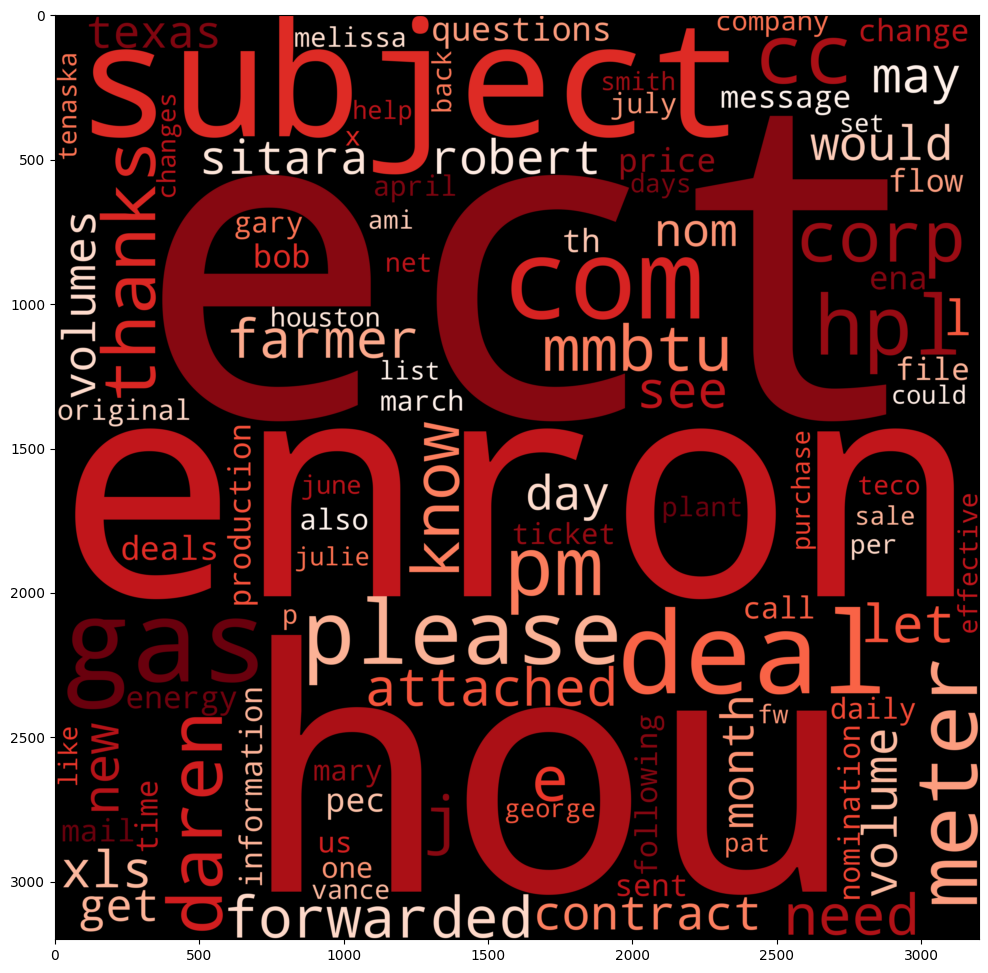

In [61]:
# график частотности слов из не спам текстов
fig = plt.figure(figsize=(20, 12))

plt.imshow(nspam_wordcloud, interpolation='bilinear')

plt.show()

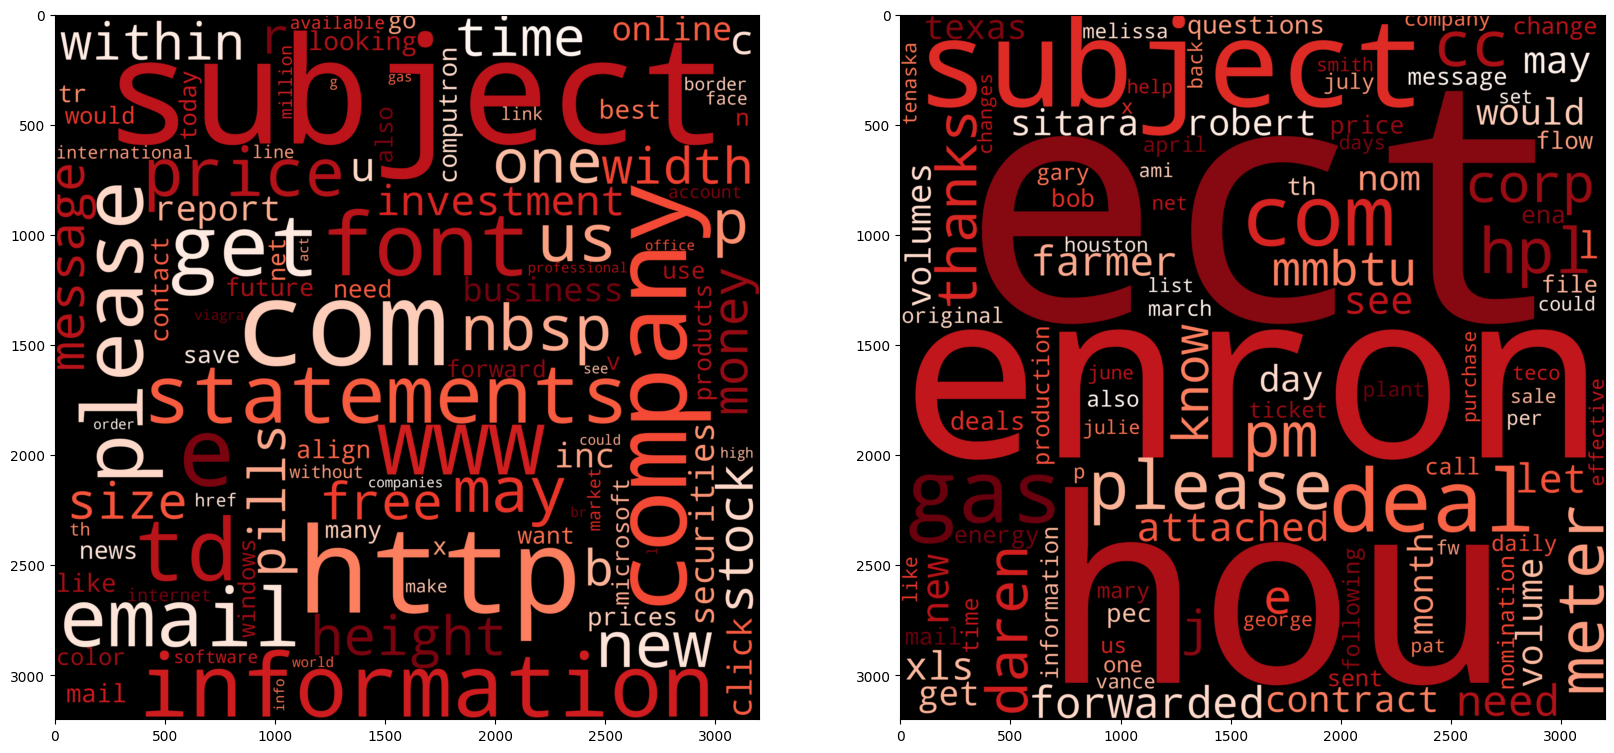

In [62]:
# изобразим все на одном графике
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')

ax2 = fig.add_subplot(1, 2, 2)
plt.imshow(nspam_wordcloud, interpolation='bilinear')

plt.show()

### Создадим эмбединги для текстов

In [63]:
import gensim.downloader as api


fasttext = api.load('glove-twitter-25')

In [64]:
import string 
from collections import Counter 


class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int=10):
        
        text = ' '.join(texts) # превращаем все в строку с разделителем пробелом
        
        # удаляем все двойные пробелы на одинарные
        while '  ' in text: 
            text = text.replace('  ', ' ')
            
        words = text.strip().lower().split() # обрезаем по сторонам, приводим к нижнему регистру и сплитим по пробелам
        
        c = Counter(words) # заводим счетчик слов
        
        # заносим в словарь все слова которые встречаются чаще, чем минимальная частота и дополнительный символ для неизвестных слов
        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        # заведем словарь индекс: слово и слово: индекс
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}
    
    def get_vocabulary(self):
        '''
            function for return vocabulary
        '''
        return self.vocabulary()
    
    def idx2word(self, idx: int):
        '''
            function for return a word by index
            params: int idx - index
            return: str - word
        '''
        # если такого индекса нет, то возвращаем <unk>
        if idx not in self._idx2word:
            return '<unk>'
        
        return self._idx2word[idx]
    
    def word2idx(self, word: str):
        '''
            function for return a index by word
            params: str word - word
            return: int - index
        '''
        word = word.lower() # переводим слова в нижний регистр 
        
        # если такого слова нет, вернем индекс <unk> 
        if word not in self._word2idx:
            return self._word2idx['<unk>']
        
        return self._word2idx[word]
    
    def encode(self, text):
        '''
            function for encoding text 
            params: text: str 
            return: encoded list
        '''
        result = []
        text = text.lower() # переводим текст в нижний регистр 
        
        for word in text.split(): # проходимся по словам из списка 
            if word in self._word2idx: # если слово есть в словаре слов, добавляем значение этого слова
                result.append(self._word2idx[word])
                
        return result
    
    def build_vectors(self, fasttext):
        '''
            function for return vectors
            params: fasttext - a model that can return the text words of their vector
            return: stack array
        '''
        vectors = []
        
        for word in self.vocabulary:
            # если в нашей модели есть векторное представлние для этогго слова - добавляем
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25)) # иначе добавляем в вектор массив нулей размером 25, так как в fasttext размеры векторов 25
                
        return np.stack(vectors) # возвращаем застаканный массив этих векторов 

### Создадим датасет для pytorch

In [69]:
import torch

In [99]:
from torch.utils.data import Dataset


class Spam(Dataset):
    def __init__(self, data: pd.DataFrame, text):
        self.text = text
        
        self.df = data # считываем датафрейм по пути
        
        texts = self.df[text].values # сохраняем в переменную все значения из колонки text 
        
        self.vocab = Vocabulary(texts, min_freq=4) # создаем словарь со значениями из texts
        
        
    def __getitem__(self, idx):
        text = self.df[self.text].iloc[idx] # достаем текст по индексу
        label = self.df['label_num'].iloc[idx] # значение таргета по индексу 
        
        text = torch.LongTensor(self.vocab.encode(text)) # тензор с векторами для слов из текста 
        label = torch.FloatTensor([label]) # тензор со значением таргетного класса в формате float
        
        return text, label
    
    def __len__(self):
        return len(self.df)

In [135]:
dataset = Spam(data, 'text') # датасет без обработки текста 

In [136]:
dataset[3]

(tensor([3136,  472, 5378,   12, 3037, 6003, 5223, 3755, 1688, 8055]),
 tensor([1.]))

In [137]:
### Поделим данные на тренировочные и тестовые
from torch.utils.data import random_split


train_dataset, test_dataset = random_split(dataset, ((int(len(dataset) * 0.8)), len(dataset) - int(len(dataset) * 0.8)))

In [138]:
### Нужно привести векторы к одинаковым размерам по самому большему вектору
from torch.nn.utils.rnn import pad_sequence


pad_idx = len(dataset.vocab.vocabulary) # длина словаря 

def collate_fn(batch):
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True) # найдем тензор максимальной длины и все остальные заполняем pad_idx 
    
    labels = torch.stack([b[1] for b in batch]) # вектор из целевых переменных
    
    return texts, labels

In [139]:
from torch.utils.data import DataLoader 

# создаем лоадеры размерами по 32 с приминением к каждому объекту collate_fn и использованием памяти для скорости
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn, pin_memory=True)

In [105]:
next(iter(train_loader)) # посмотрим на последний батч

[tensor([[11757,  5072,  4745,  ..., 12377, 12377, 12377],
         [11757,  9776, 10652,  ..., 12377, 12377, 12377],
         [11757,  3379, 10293,  ..., 12377, 12377, 12377],
         ...,
         [11757,  8520,  6550,  ..., 12377, 12377, 12377],
         [11757, 12163,  7690,  ..., 12377, 12377, 12377],
         [11757, 12163,  4031,  ..., 12377, 12377, 12377]]),
 tensor([[1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.]])]

In [106]:
### Построение модели
# TextCNN 
import torch.nn.functional as F
import torch.nn as nn


class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()
        
        #embedding(кол-во слов в словаре+паддинг, размерность эмбеддинга, паддинг индекс)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        #список сверток(на выходе они будут объеденены для входа в полносвязные слои)
        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels = 1, # принимает 1 канал
                    out_channels = 64, # отдает 64 канала
                    kernel_size = (fs, embedding_dim), # размер ядра 
                    stride = 2 # шаг страйда
                )
                for fs in [2, 3, 4]
            ]
        )
        # полносвязные слои
        self.fc = nn.Linear(3 * 64, 100) # полносвязный слой из 5*64 входных нейронов и 100 выходных
#         self.fc2 = nn.Linear(100, 10) 
        self.fc3 = nn.Linear(100, 1) # слой из 100 входных и 1 выходного
        
        self.batchnorm = nn.BatchNorm2d(64) # слой нормализации
        
        self.dropout = nn.Dropout(0.5) # 1/p * x * m 0.5 вероятность выключить нейрон(будем исключать взаимоадаптацию нейронов при обучении)
        
    def forward(self, x):
        x = self.embedding(x) # переводим объект в эмбеддинг
        x = x.unsqueeze(1) # добавим размерность(измерение канала) для свертки
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs] # пропускаем через свертки через функцию активации и уберем размерность
        
        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x] # делаем пулинг по длине, убираем ненужную размерность
        
        x = self.dropout(torch.cat(x, dim=1)) # применяем дропаут
        x = self.fc(x)
        x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.dropout(x)
        
        return self.fc3(x)
        

In [107]:
modelCNN = TextCNN(vocab_size=len(dataset.vocab.vocabulary) + 1, embedding_dim=25, pad_idx=pad_idx)

In [108]:
modelCNN

TextCNN(
  (embedding): Embedding(12378, 25, padding_idx=12377)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(2, 25), stride=(2, 2))
    (1): Conv2d(1, 64, kernel_size=(3, 25), stride=(2, 2))
    (2): Conv2d(1, 64, kernel_size=(4, 25), stride=(2, 2))
  )
  (fc): Linear(in_features=192, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [109]:
### переводим слова из готовой модели fasttext в вектора
vectors = dataset.vocab.build_vectors(fasttext)

In [110]:
vectors.shape

(12377, 25)

In [111]:
### изменим вектора на предобученные 
modelCNN.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

In [112]:
from tqdm import tqdm


def binary_accuracy(preds, y):
    '''
        params: preds - prediction our model
        params: y - true value 
        return: acc - accuracy our predictions
    '''
    # округляем вероятность отношения к тому, или иному классу [0, 1]
    rounded_preds = torch.round(torch.sigmoid(preds))
    # если предсказание равно истинному значению то correct
    correct = (rounded_preds == y).float()
    # делим сумму совпадений на общее кол-во таргетов
    acc = correct.sum() / len(correct)
    
    return acc


def train(model) -> tuple[float, float]:
    '''
        params: model - our model
        return: train_loss - train loss our model
        return: train_accuracy - train accuracy our model
    '''
    model.train() # переводим в режим обучения
    
    # инициализируем переменные
    train_loss = 0
    train_accuracy = 0
    
    
    for x, y in tqdm(train_loader, desc='train'):
        x, y = x.to(device), y.to(device) # тензоры на девайс
        
        optimizer.zero_grad() # обнуляем градиенты от батча к батчу нашего оптимизатора
        
        output = model(x) # выход модели на объекте
        
        loss = loss_fn(output, y) # считаем лосс
        
        train_loss += loss.item()
    
        train_accuracy += binary_accuracy(output, y)
        
        loss.backward() # Метод обратного распространения ошибки
        
        optimizer.step() # шаг оптимизатора
        
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    
    return train_loss, train_accuracy

In [113]:
import torch


@torch.inference_mode()
def evaluate(model) -> tuple[float, float]:
    '''
        params: model - our model
        return: test_loss - test loss our model
        return: test_accuracy - test accuracy our model
    '''
    model.eval() # переводим в режим предсказаний
    
    # инициализируем переменные
    test_loss = 0
    test_accuracy = 0
    
    for x, y in tqdm(test_loader, desc='evaluation'):
        x, y = x.to(device), y.to(device) # тензоры батча к девайсу
        
        output = model(x) # выход модели (forward pass)
        
        loss = loss_fn(output, y) # считаем лосс
        
        test_loss += loss.item()
        
        test_accuracy += binary_accuracy(output, y)
        
    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)
    
    return test_loss, test_accuracy

In [114]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    test_loss: list[float],
    train_accuracy: list[float],
    test_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))
    
    plt.title(title + ' loss')
    
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.legend()
    plt.grid()
    
    plt.show()
    
    plt.figure(figsize=(16, 8))
    
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(test_accuracy, label='test accuracy')
    plt.legend()
    plt.grid()
    
    plt.show()

In [115]:
def whole_train_test_cycle(model, num_epochs, title):
    train_loss_hist, test_loss_hist = [], []
    train_accuracy_hist, test_accuracy_hist = [], []
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        test_loss, test_accuracy = evaluate(model)
        
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)
        
        train_accuracy_hist.append(train_accuracy)
        test_accuracy_hist.append(test_accuracy)
        
        clear_output()
        
        plot_stats(
            train_loss_hist, test_loss_hist,
            train_accuracy_hist, test_accuracy_hist,
            title
        )

In [116]:
def whole_train_test_cycle(model, num_epochs, title):
    train_loss_hist, test_loss_hist = [], []
    train_accuracy_hist, test_accuracy_hist = [], []
    best_model = model 
    best_score = 0
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        test_loss, test_accuracy = evaluate(model)
        
        if test_accuracy > best_score:
            best_score = test_accuracy
            best_model = model
#         lr_shed.step(train_loss)
        
        print(f'train loss: {train_loss} and train accuracy: {train_accuracy} for epoch {epoch}')
        print(f'test loss: {test_loss} and test accuracy: {test_accuracy} for epoch {epoch}')
        
    return best_model, best_score

In [117]:
from torch.optim import Adam

In [118]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [119]:
loss_fn = nn.BCEWithLogitsLoss()

In [120]:
modelCNN = modelCNN.to(device)

optimizer = Adam(modelCNN.parameters(), lr=1e-3)


best_model, best_score = whole_train_test_cycle(modelCNN, 10, 'Text CNN 10 cycles')

evaluation: 100%|██████████| 33/33 [00:00<00:00, 79.76it/s]


train loss: 0.48993163383924043 and train accuracy: 0.7646634578704834 for epoch 0
test loss: 0.27852292268565204 and test accuracy: 0.8958333730697632 for epoch 0


evaluation: 100%|██████████| 33/33 [00:00<00:00, 122.28it/s]


train loss: 0.23521414377654976 and train accuracy: 0.90625 for epoch 1
test loss: 0.13656019430720445 and test accuracy: 0.9545454978942871 for epoch 1


evaluation: 100%|██████████| 33/33 [00:00<00:00, 123.69it/s]


train loss: 0.13602569037331985 and train accuracy: 0.9466345906257629 for epoch 2
test loss: 0.10361280484181462 and test accuracy: 0.9659091234207153 for epoch 2


evaluation: 100%|██████████| 33/33 [00:00<00:00, 120.76it/s]


train loss: 0.08678379611004718 and train accuracy: 0.96875 for epoch 3
test loss: 0.0796672644262964 and test accuracy: 0.9763258099555969 for epoch 3


evaluation: 100%|██████████| 33/33 [00:00<00:00, 105.67it/s]


train loss: 0.05805537901782932 and train accuracy: 0.9800480604171753 for epoch 4
test loss: 0.06739904202351515 and test accuracy: 0.9745179414749146 for epoch 4


evaluation: 100%|██████████| 33/33 [00:00<00:00, 124.49it/s]


train loss: 0.04001514366492092 and train accuracy: 0.9877403974533081 for epoch 5
test loss: 0.06304757408515523 and test accuracy: 0.9745179414749146 for epoch 5


evaluation: 100%|██████████| 33/33 [00:00<00:00, 124.80it/s]


train loss: 0.02792008478046717 and train accuracy: 0.9918269515037537 for epoch 6
test loss: 0.06299705080208227 and test accuracy: 0.9764118790626526 for epoch 6


evaluation: 100%|██████████| 33/33 [00:00<00:00, 115.57it/s]


train loss: 0.021749295335925685 and train accuracy: 0.9925480484962463 for epoch 7
test loss: 0.0647886897028057 and test accuracy: 0.9745179414749146 for epoch 7


evaluation: 100%|██████████| 33/33 [00:00<00:00, 121.45it/s]


train loss: 0.01095536016263605 and train accuracy: 0.9973557591438293 for epoch 8
test loss: 0.06542246204546907 and test accuracy: 0.975464940071106 for epoch 8


evaluation: 100%|██████████| 33/33 [00:00<00:00, 120.98it/s]

train loss: 0.011980726214068664 and train accuracy: 0.9963942170143127 for epoch 9
test loss: 0.06955229562784855 and test accuracy: 0.9745179414749146 for epoch 9


In [94]:
best_model, best_score

(TextCNN(
   (embedding): Embedding(10823, 25, padding_idx=10822)
   (convs): ModuleList(
     (0): Conv2d(1, 64, kernel_size=(2, 25), stride=(2, 2))
     (1): Conv2d(1, 64, kernel_size=(3, 25), stride=(2, 2))
     (2): Conv2d(1, 64, kernel_size=(4, 25), stride=(2, 2))
   )
   (fc): Linear(in_features=192, out_features=100, bias=True)
   (fc3): Linear(in_features=100, out_features=1, bias=True)
   (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (dropout): Dropout(p=0.5, inplace=False)
 ),
 tensor(0.9915, device='cuda:0'))